# Exploratory Data Analysis - Bike lane data

## 1. Loading packages and libraries

We'll start by importing the necessary packages

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For visualisations
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# For UML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PCA
from sklearn.decomposition import PCA

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## 2. Loading data

This dataset contains data from one sensor installed at an electric charger spot.

The information received about the columns are the following:
*	**Time:** Time of measurement
*	**Battery:** Battery voltage at packet transmission (the nominal voltage of the battery package is 3V, and the capacity is 6AH)
*   **Temperature:** Calibrates the magnetic field readings, which are highly dependent on the temperature
*	**X:** Magnetic field reading in the x direction
*	**Y:** Magnetic field reading in the y direction
*	**Z:** Magnetic field reading in the z direction
*   **Radar data:**
    *   **0_radar:** Signal reflection strength in the 20 – 27.5 cm
    *	**1_radar:** Signal reflection strength in the 27.5 – 35 cm
    *	**2_radar:** Signal reflection strength in the 35 – 42.5 cm
    *	**3_radar:** Signal reflection strength in the 42.5 – 50 cm
    *	**4_radar:** Signal reflection strength in the 50 – 57.5 cm
    *	**5_radar:** Signal reflection strength in the 57.5 – 65 cm
    *	**6_radar:** Signal reflection strength in the 65 – 72.5 cm
    *	**7_radar:** Signal reflection strength in the 72.5 – 80 cm
*	**Package_type:**
    *	**PackageType.CHANGE =** A big change in magnetic field is detected. The magnetic field coordinates (x, y and z) need to change by 30 points on at least 1 axis, to be classified as a CHANGE packet.
    *	**PackageType.HEART_BEAT =** Regular heartbeat if no major changes in magnetic field are detected
*	**f_cnt:** The number of packages transmitted since last network registration
*	**dr:** Data rate parameter in LoRaWAN. It ranges between 1 and 5 where 1 is the slowest transmission data rate and 5 is the highest. This datarate is scaled by the network server depending on the signal quality of the past packages send.
*	**SNR:** Signal to noise ratio – the higher value, the better the signal quality
*	**RSSI:** Signal strength – the higher value, the better the signal quality

In [2]:
%cd ../../

/workspaces/2nd_semester_project


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# Loading the data
df_combined_full = pd.read_csv('data/combined_full_df.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df_combined_full.head()

,time,battery,temperature,x,y,z,radar_0,radar_1,radar_2,radar_3,...,surface_pressure,cloud_cover,et0_fao_evapotranspiration,wind_speed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,psensor,id,mag_cluster,radar_cluster
0,2024-03-01 00:03:31.999,3.16,5.500,312.0,-465.0,-991.0,4.0,5.0,6.0,6.0,...,1001.9787,100.0,0.006267,16.904673,5.3805,0.296,BUILDING,2024-03-01 00:03:31.999_BUILDING,no_detection,no_detection
1,2024-03-01 00:13:30.999,3.16,5.500,309.0,-463.0,-992.0,4.0,5.0,6.0,6.0,...,1001.9787,100.0,0.006267,16.904673,5.3805,0.296,BUILDING,2024-03-01 00:13:30.999_BUILDING,no_detection,no_detection
2,2024-03-01 00:23:31.999,3.16,5.375,312.0,-466.0,-987.0,4.0,5.0,6.0,6.0,...,1001.9787,100.0,0.006267,16.904673,5.3805,0.296,BUILDING,2024-03-01 00:23:31.999_BUILDING,no_detection,no_detection
3,2024-03-01 00:33:33.017,3.16,5.375,312.0,-464.0,-997.0,6.0,5.0,5.0,5.0,...,1001.9787,100.0,0.006267,16.904673,5.3805,0.296,BUILDING,2024-03-01 00:33:33.017_BUILDING,no_detection,no_detection
4,2024-03-01 00:43:33.017,3.16,5.375,310.0,-467.0,-993.0,6.0,5.0,5.0,5.0,...,1001.9787,100.0,0.006267,16.904673,5.3805,0.296,BUILDING,2024-03-01 00:43:33.017_BUILDING,no_detection,no_detection


In [4]:
#removing the building sensor data found in psensor column
df_combined_full = df_combined_full[df_combined_full['psensor'] == 'BIKELANE']

## 3. Checking for missing values and duplicates

In [5]:
# Checking for missing values
df_combined_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7595 entries, 7665 to 15259
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        7595 non-null   object 
 1   battery                     7595 non-null   float64
 2   temperature                 7595 non-null   float64
 3   x                           7595 non-null   float64
 4   y                           7595 non-null   float64
 5   z                           7595 non-null   float64
 6   radar_0                     7595 non-null   float64
 7   radar_1                     7595 non-null   float64
 8   radar_2                     7595 non-null   float64
 9   radar_3                     7595 non-null   float64
 10  radar_4                     7595 non-null   float64
 11  radar_5                     7595 non-null   float64
 12  radar_6                     7595 non-null   float64
 13  radar_7                     7595 n

In [6]:
# Convert the 'time' column to datetime
df_combined_full['time'] = pd.to_datetime(df_combined_full['time'])

# Checking the datatype of each column again
df_combined_full.dtypes

time                          datetime64[ns]
battery                              float64
temperature                          float64
x                                    float64
y                                    float64
z                                    float64
radar_0                              float64
radar_1                              float64
radar_2                              float64
radar_3                              float64
radar_4                              float64
radar_5                              float64
radar_6                              float64
radar_7                              float64
package_type                          object
f_cnt                                float64
dr                                   float64
snr                                  float64
rssi                                 float64
hw_fw_version                         object
time_hour                             object
temperature_2m                       float64
relative_h

We can see that the 'time' variable has changed from object to datetime64

Now we'll check for any duplicated rows in the dataset

In [7]:
# Checking if there are any duplicated rows
num_duplicate_rows = df_combined_full.duplicated().sum()
print("Number of duplicated rows: ", num_duplicate_rows)

Number of duplicated rows:  0


This tells us that there are no duplicated rows.

We'll also check the number of unique values in each column:

In [8]:
# Checking the number of unique values in each column
df_combined_full.nunique()

time                          7595
battery                          3
temperature                    238
x                              512
y                              455
z                              817
radar_0                        137
radar_1                        117
radar_2                        120
radar_3                        109
radar_4                         81
radar_5                         53
radar_6                         39
radar_7                         26
package_type                     2
f_cnt                         2628
dr                               5
snr                             92
rssi                            23
hw_fw_version                    1
time_hour                     1396
temperature_2m                 335
relative_humidity_2m          1348
precipitation                   27
surface_pressure              1379
cloud_cover                    396
et0_fao_evapotranspiration    1035
wind_speed_10m                 834
soil_temperature_0_t

## 4. Feature Engineering

Before starting on the EDA, we'll make some extra features in order to get more information about the data.

In [9]:
#Adding two hours to datetime to match the timezone
df_combined_full['time'] = df_combined_full['time'] + pd.Timedelta(hours=2)

In [10]:
# Making a new column including only the date from the 'time' variable
df_combined_full['date'] = df_combined_full['time'].dt.date

# Making a new column including only the hour from the 'time' variable
df_combined_full['hour'] = df_combined_full['time'].dt.hour

# Making a new column including the day of week from the 'time' variable
df_combined_full['day_of_week'] = df_combined_full['time'].dt.dayofweek

# And another column containing the name of the day
df_combined_full['day_name'] = df_combined_full['time'].dt.day_name()

In [11]:
# Checking how these new variables look
df_combined_full[['time','date', 'hour', 'day_of_week', 'day_name']].sample(10)

,time,date,hour,day_of_week,day_name
8473,2024-03-07 09:35:25.618,2024-03-07,9,3,Thursday
13488,2024-04-17 22:37:13.041,2024-04-17,22,2,Wednesday
9250,2024-03-13 07:56:22.567,2024-03-13,7,2,Wednesday
12421,2024-04-09 18:46:16.176,2024-04-09,18,1,Tuesday
14369,2024-04-24 15:58:08.195,2024-04-24,15,2,Wednesday
9473,2024-03-15 04:14:11.191,2024-03-15,4,4,Friday
9082,2024-03-11 23:01:38.386,2024-03-11,23,0,Monday
13834,2024-04-20 14:22:12.324,2024-04-20,14,5,Saturday
12285,2024-04-08 09:05:22.894,2024-04-08,9,0,Monday
10380,2024-03-23 08:45:33.353,2024-03-23,8,5,Saturday


## 5. Exploratory Data Analysis

Now we'll start on the EDA. Firstly, we'll look at the descriptive statistics for all of the numeric columns. For this we'll use the pandas describe command.

In [12]:
# Generating descriptive statistics
df_combined_full.describe()

,time,battery,temperature,x,y,z,radar_0,radar_1,radar_2,radar_3,...,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,et0_fao_evapotranspiration,wind_speed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,hour,day_of_week
count,7595,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,...,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000,7595.000000
mean,2024-04-01 02:38:45.539380224,3.058362,7.119519,-215.347070,3.406452,-586.071626,15.649243,14.311784,14.331007,12.603160,...,81.769965,0.096748,1007.596886,67.455103,0.055191,14.325402,6.134081,0.257049,11.502304,3.127452
min,2024-03-01 02:00:32.251000,3.040000,-2.250000,-547.000000,-1007.000000,-1475.000000,3.000000,3.000000,3.000000,3.000000,...,35.114860,0.000000,977.366150,0.000000,0.000000,0.360000,-0.069500,0.197000,0.000000,0.000000
25%,2024-03-16 05:29:23.803000064,3.060000,4.125000,-261.000000,-27.000000,-675.000000,5.000000,5.000000,5.000000,5.000000,...,74.371056,0.000000,1001.172500,32.100000,0.000000,9.346143,3.880500,0.240000,5.000000,1.000000
50%,2024-04-01 11:19:35.094000128,3.060000,6.375000,-214.000000,-19.000000,-596.000000,6.000000,6.000000,6.000000,6.000000,...,84.850395,0.000000,1006.874700,88.800000,0.022985,14.264361,5.930500,0.256000,12.000000,3.000000
75%,2024-04-16 21:35:55.408999936,3.060000,9.250000,-170.000000,-7.000000,-499.000000,7.000000,7.000000,6.000000,6.000000,...,92.476695,0.000000,1014.805360,100.000000,0.077847,18.003600,8.230500,0.272000,18.000000,5.000000
max,2024-05-01 01:53:43.429000,3.080000,30.500000,288.000000,786.000000,16.000000,173.000000,182.000000,236.000000,151.000000,...,100.000000,4.600000,1029.454500,100.000000,0.375001,39.254856,14.730500,0.355000,23.000000,6.000000
std,NaN,0.011727,4.684277,84.358753,135.447317,168.694245,26.222151,22.729587,24.152143,19.906398,...,13.331053,0.355021,10.022354,36.249421,0.075169,6.307576,3.101520,0.025011,7.193447,2.050220


Next we'll check the number of datapoints each day

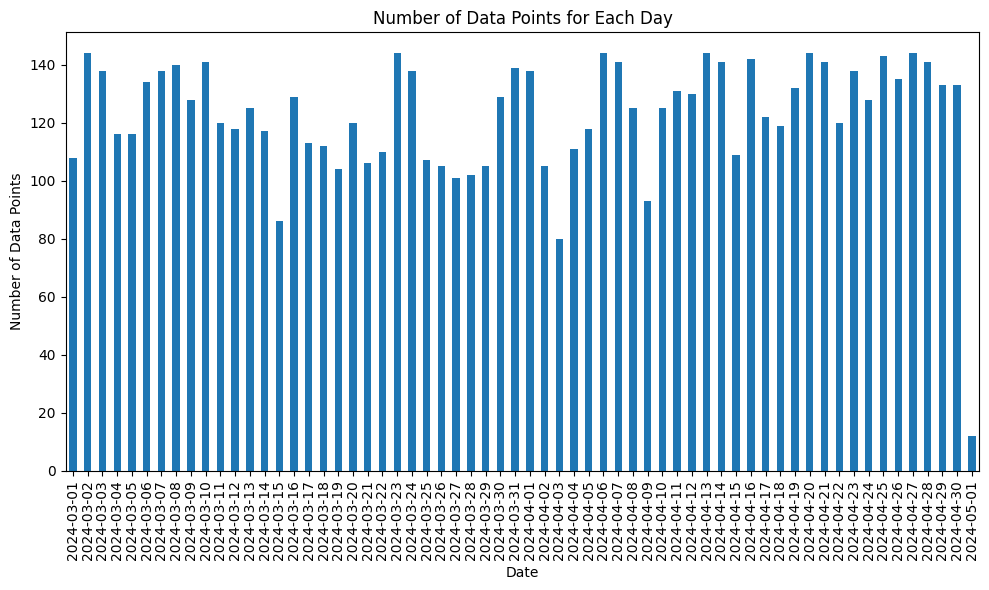

In [13]:
# Grouping by date and counting the number of data points
daily_counts = df_combined_full.groupby('date').size()

# Plotting the number of data points for each day using plt
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Data Points for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Package type variable

Next we'll look at the package type variable. Firstly we'll check which unique values the variable contains.

In [14]:
# Checking the unique values in package type
df_combined_full['package_type'].unique()

array(['PackageType.HEART_BEAT', 'PackageType.CHANGE'], dtype=object)

We now know that the variable contains two unique values; Package.Type.CHANGE and PackageType.HEART_BEAT.

From the information about the dataset we know that CHANGE is used for datapoints where a big change in magnetic field is detected and HEART_BEAT is used when there is no major changes in the magnetic field.

We can check the distribution of these two package types.

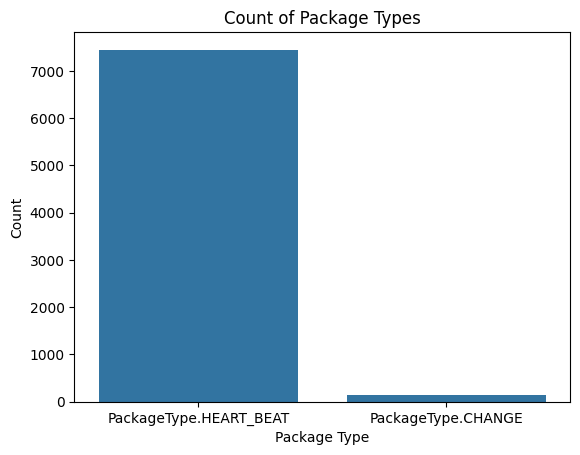

In [15]:
# Plotting the distribution of package types
plt.figure()
sns.countplot(data=df_combined_full, x='package_type')
plt.title('Count of Package Types')
plt.xlabel('Package Type')
plt.ylabel('Count')
plt.show()

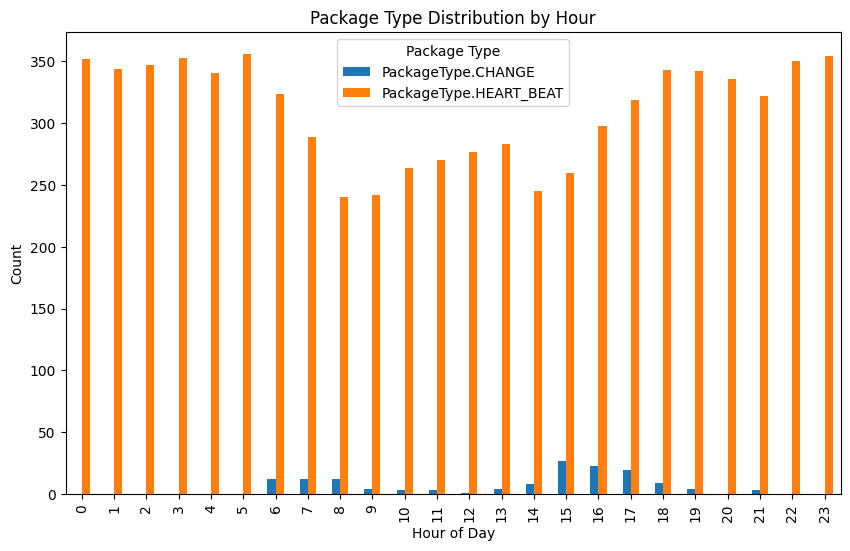

In [16]:
# Grouping the package type based on hour
hourly_counts = df_combined_full.groupby(['hour', 'package_type']).size().unstack(fill_value=0)

# Plotting the package type distribution by hour
hourly_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.show()

This plot tells us that there are more changes in the parking lot between 04:00 and 19:00. This might indicate that there are more people parking cars in this time slot. 

We'll also look at the distribution by day of week.

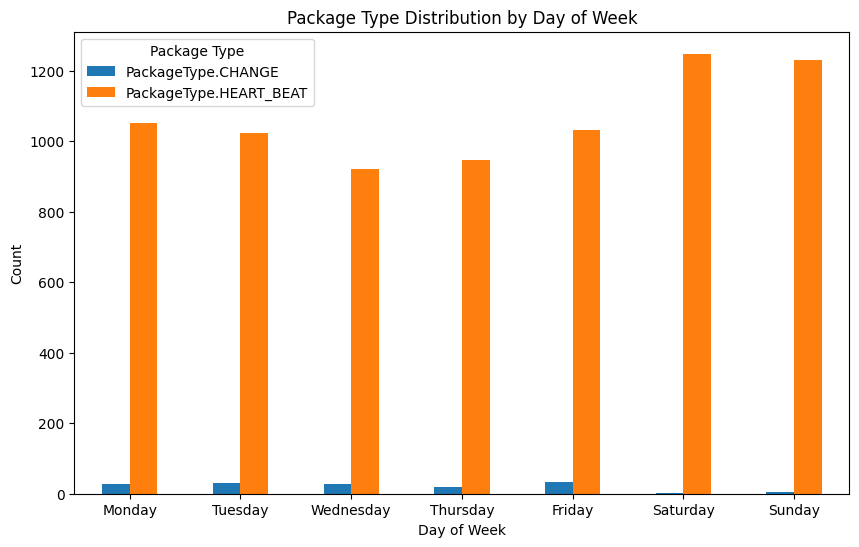

In [17]:
# Grouping the package type based on day of week
day_of_week_counts = df_combined_full.groupby(['day_name', 'package_type']).size().unstack(fill_value=0)

# Specifying the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reordering the index based on the specified day order
day_of_week_counts = day_of_week_counts.reindex(day_order)

# Plotting the package type distribution by day of week
day_of_week_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.xticks(rotation=0)
plt.show()

This plot indicates that there are not many people parking saturday and sunday. 

We would also like to know how long the car is parked on average.

In [18]:
# Creating two new dataframes. The first dataframe is filtered to only include PackageType.CHANGE events and the second dataframe wil only include PackageType.HEART_BEAT
changes = df_combined_full[df_combined_full['package_type'] == 'PackageType.CHANGE']
heart_beats = df_combined_full[df_combined_full['package_type'] == 'PackageType.HEART_BEAT']

In [19]:
# Calculating parking duration for each change
changes = changes.copy()  # Creating a copy of the dataframe to get rid of warnings
changes['parking_duration'] = changes['time'].diff()

# Calculating the average parking duration
average_parking_duration = changes['parking_duration'].mean()

print("Average parking duration:", average_parking_duration)

Average parking duration: 0 days 10:07:20.024545454


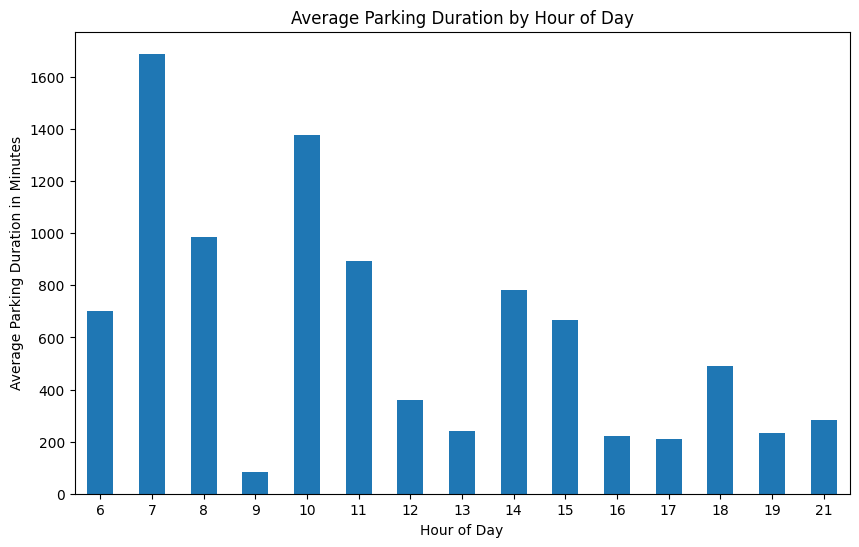

In [20]:
# Calculating parking duration in minutes for each change
changes['parking_duration_minutes'] = changes['parking_duration'].dt.total_seconds() / 60

# Grouping by hour and calculating the mean parking duration in minutes
hourly_avg_parking_duration = changes.groupby('hour')['parking_duration_minutes'].mean()

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
hourly_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

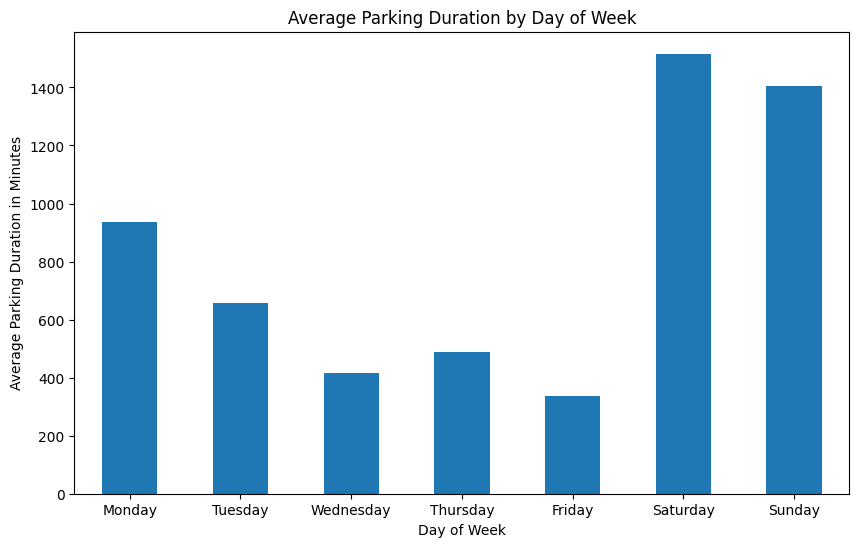

In [21]:
# Grouping by hour and calculating the mean parking duration in minutes
daily_avg_parking_duration = changes.groupby('day_name')['parking_duration_minutes'].mean()

# Reordering the index based on the specified day order from before
daily_avg_parking_duration = daily_avg_parking_duration.reindex(day_order)

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
daily_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

Correlation between package type and magnetic field

In [22]:
# Convert 'package_type' to numeric codes
df_combined_full['package_type_encoded'] = pd.Categorical(df_combined_full['package_type']).codes
df_combined_full['package_type_encoded'].head()

7665    1
7666    1
7667    1
7668    1
7669    1
Name: package_type_encoded, dtype: int8

PackageType.CHANGE is now represented by 0 and PackageType.HEART_BEAT is represented by 1

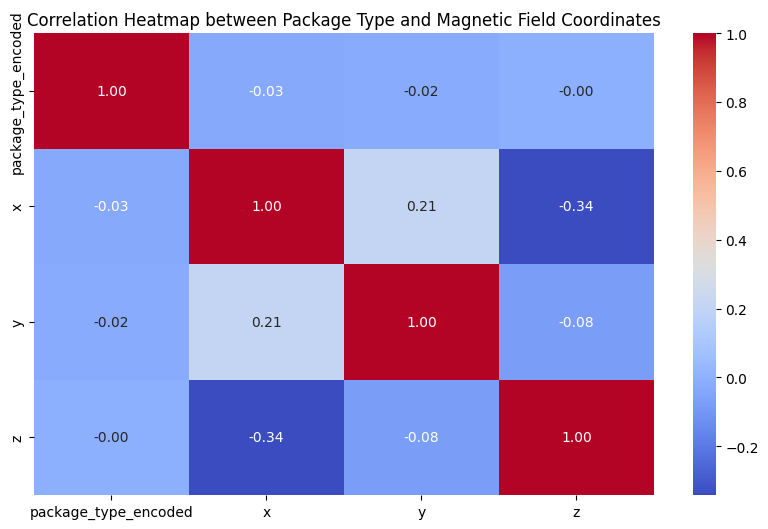

In [23]:
# Calculating correlation matrix
correlation_matrix = df_combined_full[['package_type_encoded', 'x', 'y', 'z']].corr()

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Package Type and Magnetic Field Coordinates')
plt.show()

Before going on to the next variable, we'll look at how much x, y and z need to change in order for the package type to change from HEART_BEAT to CHANGE.

In [24]:
df_package_diff = df_combined_full[['time', 'x', 'y', 'z', 'package_type']]
df_package_diff = df_package_diff.copy() # Making a copy of the dataframe to get rid of warnings
df_package_diff['x_diff'] = df_package_diff['x'].diff()
df_package_diff['y_diff'] = df_package_diff['y'].diff()
df_package_diff['z_diff'] = df_package_diff['z'].diff()
df_package_diff.head()

,time,x,y,z,package_type,x_diff,y_diff,z_diff
7665,2024-03-01 02:00:32.251,-253.0,-27.0,-630.0,PackageType.HEART_BEAT,NaN,NaN,NaN
7666,2024-03-01 02:10:32.251,-254.0,-20.0,-627.0,PackageType.HEART_BEAT,-1.0,7.0,3.0
7667,2024-03-01 02:20:33.352,-254.0,-23.0,-635.0,PackageType.HEART_BEAT,0.0,-3.0,-8.0
7668,2024-03-01 02:30:34.352,-256.0,-25.0,-628.0,PackageType.HEART_BEAT,-2.0,-2.0,7.0
7669,2024-03-01 02:40:33.352,-253.0,-28.0,-630.0,PackageType.HEART_BEAT,3.0,-3.0,-2.0


### SNR

Signal to noise ratio – the higher value, the better the signal quality

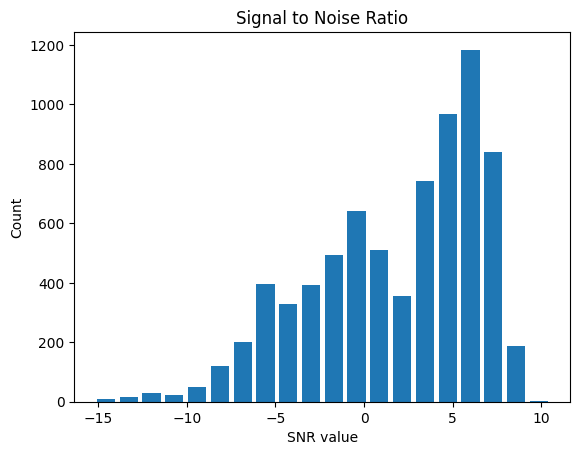

In [25]:
plt.hist(df_combined_full['snr'], bins =20, histtype='bar', rwidth=0.8)
plt.title('Signal to Noise Ratio')
plt.xlabel('SNR value')
plt.ylabel('Count')
plt.show()

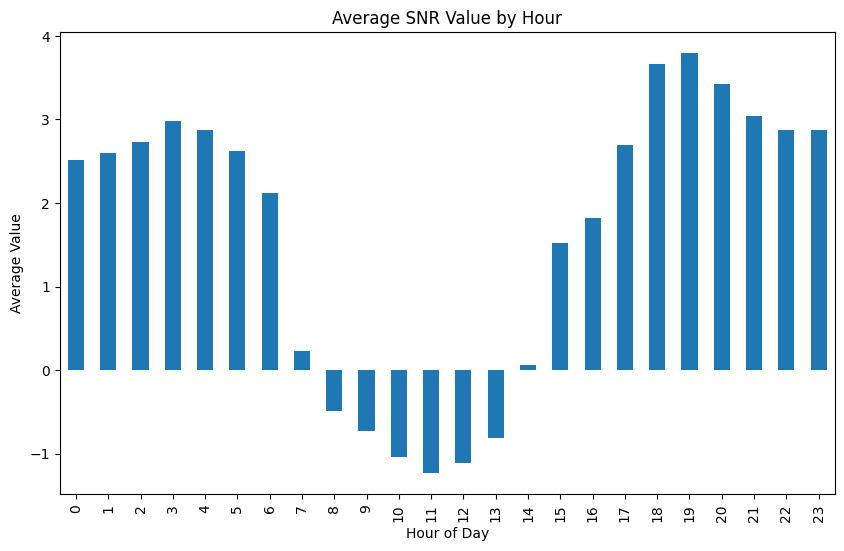

In [26]:
# Grouping the mean SNR value by hour
hourly_mean_snr = df_combined_full.groupby('hour')['snr'].mean()

# Plotting
hourly_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

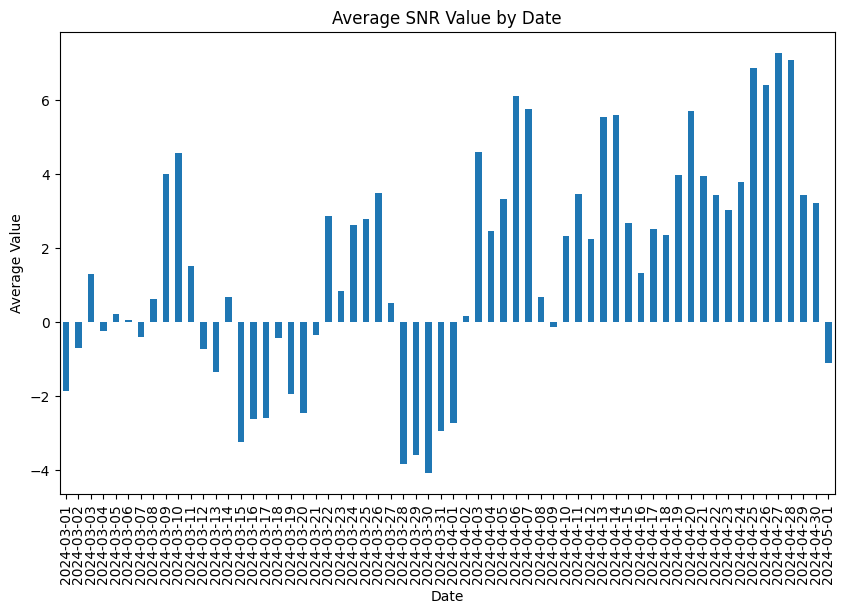

In [27]:
# Grouping the mean SNR value by date
daily_mean_snr = df_combined_full.groupby('date')['snr'].mean()

# Plotting
daily_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### RSSI

Signal strength – the higher value, the better the signal quality

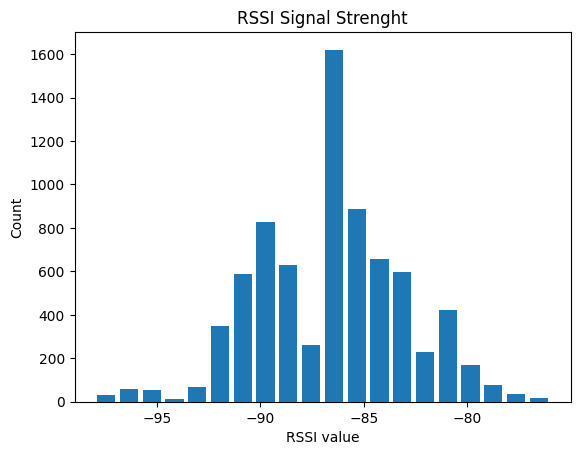

In [28]:
plt.hist(df_combined_full['rssi'], bins =20, histtype='bar', rwidth=0.8)
plt.title('RSSI Signal Strenght')
plt.xlabel('RSSI value')
plt.ylabel('Count')
plt.show()

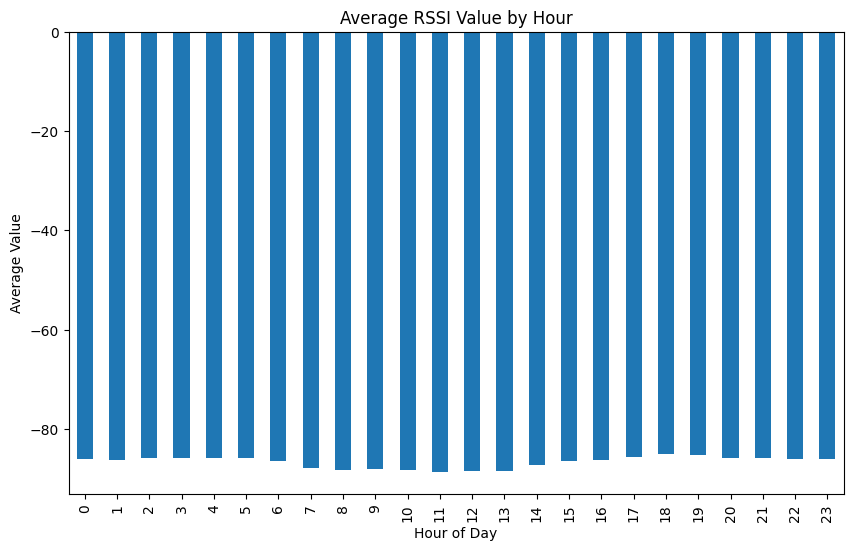

In [29]:
# Grouping the mean RSSI value by hour
hourly_mean_rssi = df_combined_full.groupby('hour')['rssi'].mean()

# Plotting
hourly_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSSI Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

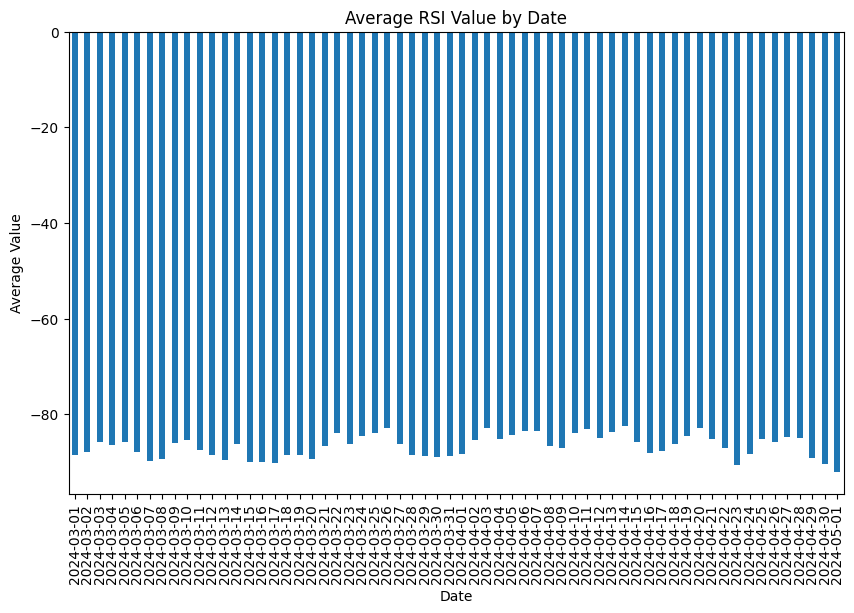

In [30]:
# Grouping the mean SNR value by hour
daily_mean_rssi = df_combined_full.groupby('date')['rssi'].mean()

# Plotting
daily_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSI Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### Battery variable

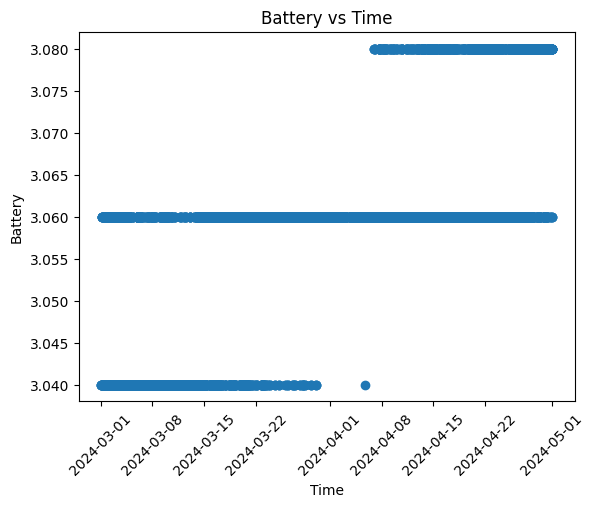

In [31]:
# here I want to plot variable 'battery':
plt.figure()
plt.scatter(x=df_combined_full["time"] , y=df_combined_full["battery"])
plt.title('Battery vs Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Battery')
plt.show()

### Temperature

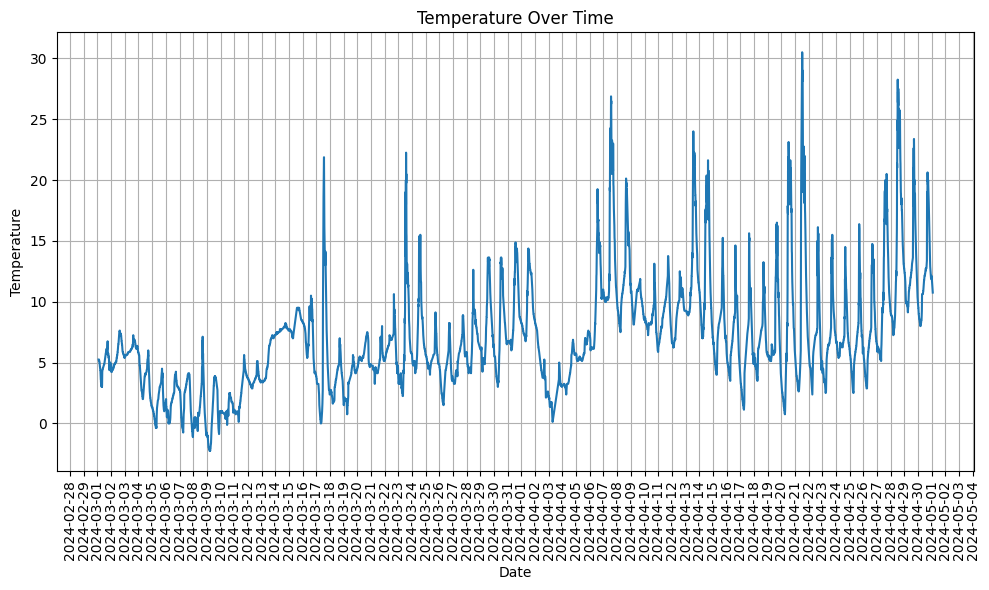

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['temperature'], linestyle='-')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

In [33]:
# Creating a new dataset including only time and temperature
df_temperature = df_combined_full[["time", "temperature"]]

# Setting the datetime variable as index
df_temperature = df_temperature.set_index(['time'])

# Resampling the temperature dataset on hour
df_temperature_hourly = df_temperature.resample("H").mean()


In [34]:
# Plotting the average temperature each hour
alt.Chart((df_temperature_hourly).reset_index()).mark_rect().encode(
    alt.X('hoursminutes(time):O', title='hour of day'),
    alt.Y('monthdate(time):O', title='date'),
    alt.Color('temperature:Q', title='temperature')
)

alt.Chart(...)

# X over time

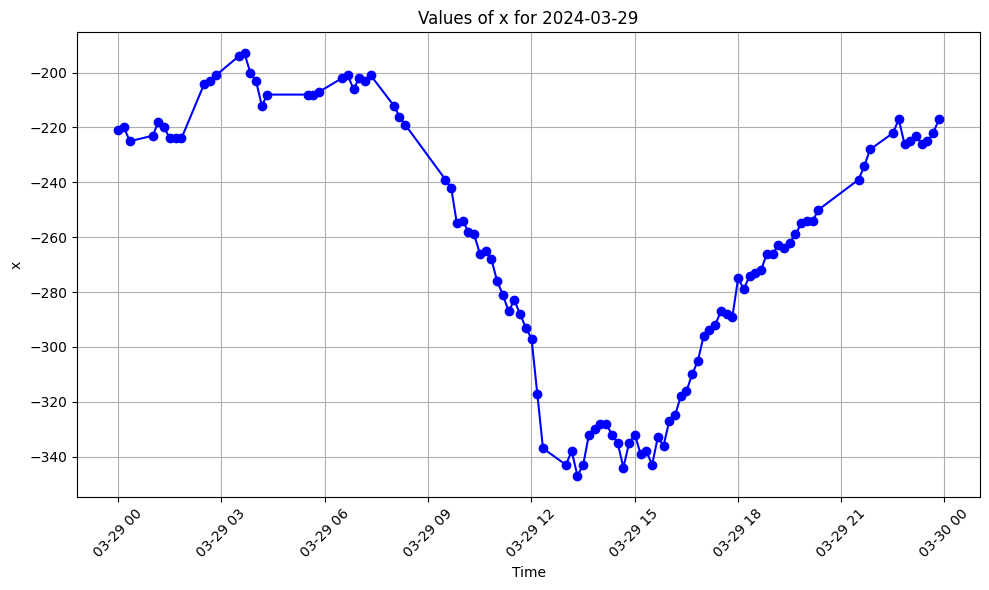

In [35]:
specific_date = '2024-03-29'  # Example date

# Filter the DataFrame for the specific date
df_specific_date = df_combined_full[df_combined_full['time'].dt.date == pd.to_datetime(specific_date).date()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_date['time'], df_specific_date['x'], color='blue', marker='o', linestyle='-')
plt.title(f'Values of x for {specific_date}')
plt.xlabel('Time')
plt.ylabel('x')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Normalizing the data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_combined_full[['x', 'y', 'z']])

/tmp/ipykernel_20935/3125953888.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_time_range[['x', 'y', 'z']] = normalized_data


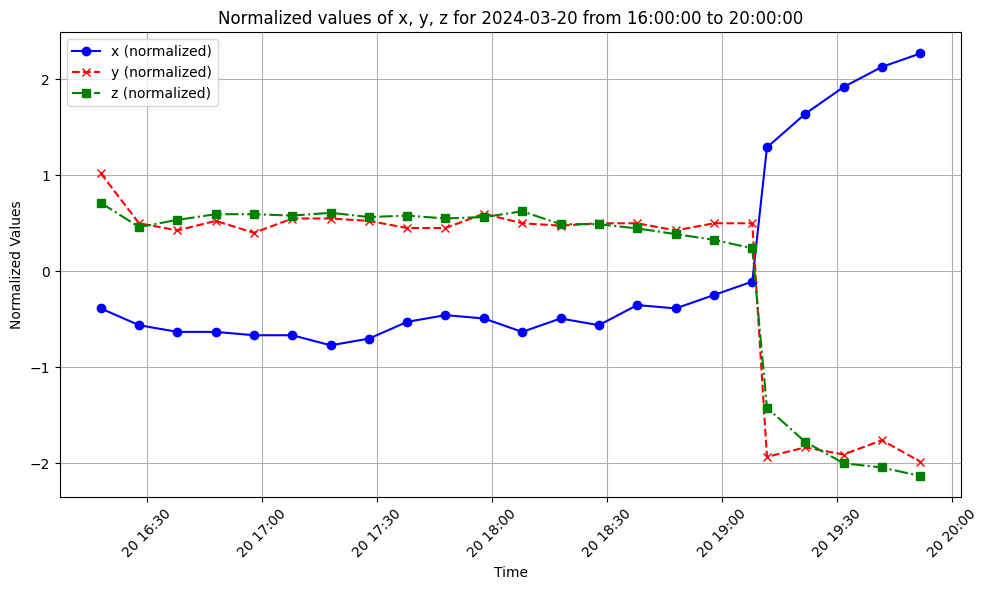

In [37]:
# Convert 'time' column to datetime if it's not already in datetime format
df_combined_full['time'] = pd.to_datetime(df_combined_full['time'])

# Specify the date and time range
specific_date = '2024-03-20'
start_time = '16:00:00'
end_time = '20:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df_combined_full[(df_combined_full['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df_combined_full['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df_combined_full['time'].dt.time <= pd.to_datetime(end_time).time())]

# Selecting the columns to be normalized
data_to_normalize = df_specific_time_range[['x', 'y', 'z']]

# Applying StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

# Adding normalized data back to the DataFrame
df_specific_time_range[['x', 'y', 'z']] = normalized_data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['x'], label='x (normalized)', color='blue', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['y'], label='y (normalized)', color='red', marker='x', linestyle='--')
plt.plot(df_specific_time_range['time'], df_specific_time_range['z'], label='z (normalized)', color='green', marker='s', linestyle='-.')
plt.title(f'Normalized values of x, y, z for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Weather data visuals

In [38]:
df_combined_full.columns

Index(['time', 'battery', 'temperature', 'x', 'y', 'z', 'radar_0', 'radar_1',
       'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7',
       'package_type', 'f_cnt', 'dr', 'snr', 'rssi', 'hw_fw_version',
       'time_hour', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'surface_pressure', 'cloud_cover', 'et0_fao_evapotranspiration',
       'wind_speed_10m', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm',
       'psensor', 'id', 'mag_cluster', 'radar_cluster', 'date', 'hour',
       'day_of_week', 'day_name', 'package_type_encoded'],
      dtype='object')

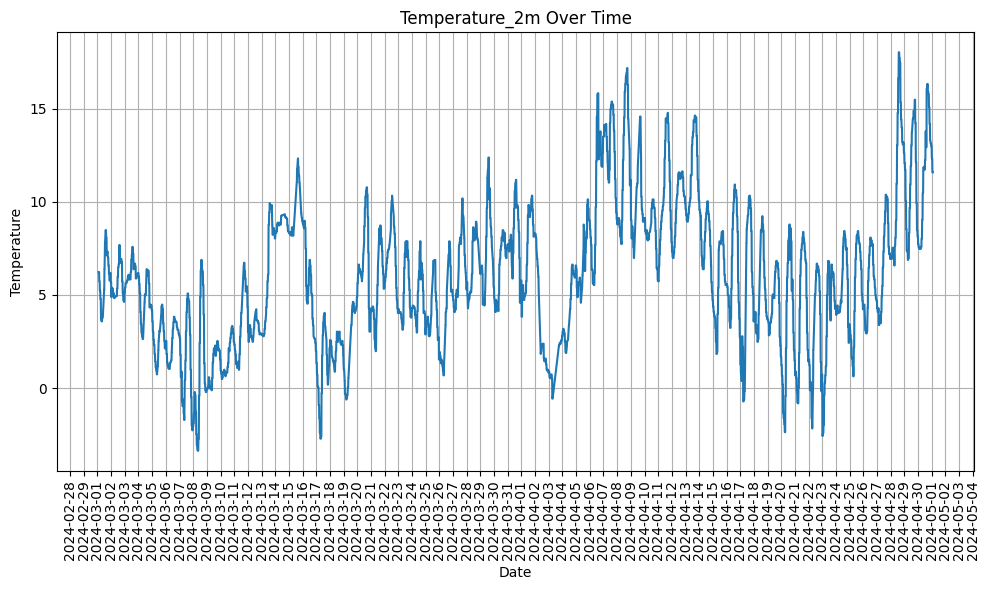

In [39]:
# Plotting temperature_2m over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['temperature_2m'], linestyle='-')
plt.title('Temperature_2m Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

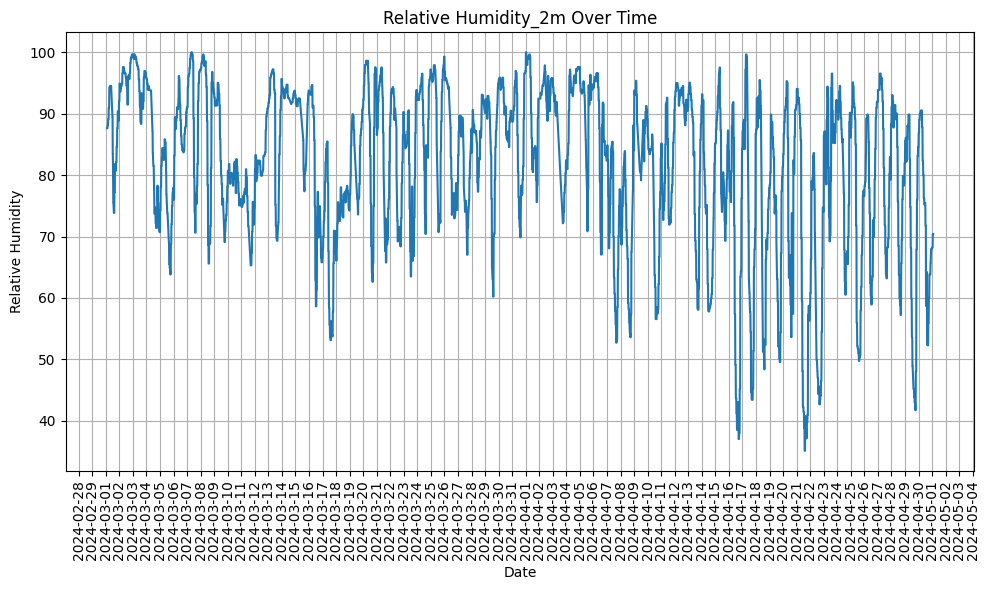

In [40]:
# plotting the relative_humidity_2m over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['relative_humidity_2m'], linestyle='-')
plt.title('Relative Humidity_2m Over Time')
plt.xlabel('Date')
plt.ylabel('Relative Humidity')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


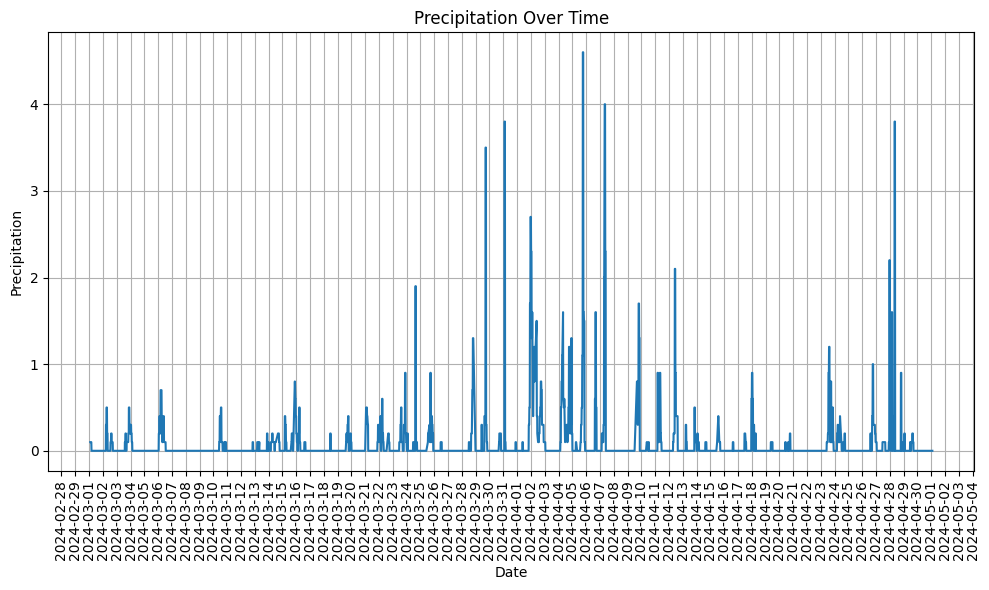

In [41]:
# plotting the precipitation over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['precipitation'], linestyle='-')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

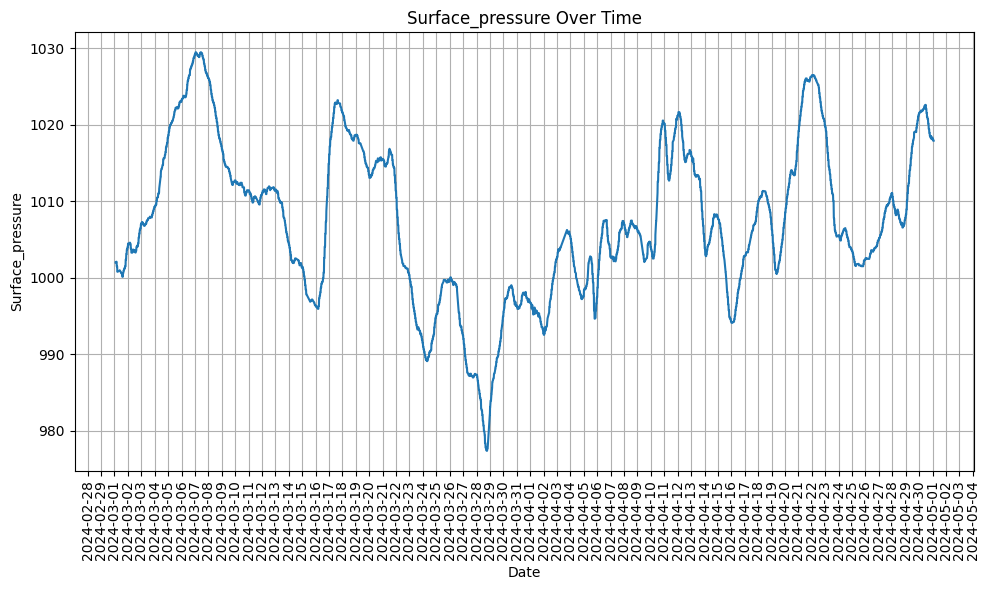

In [42]:
# plotting the surface_pressure over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['surface_pressure'], linestyle='-')
plt.title('Surface_pressure Over Time')
plt.xlabel('Date')
plt.ylabel('Surface_pressure')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

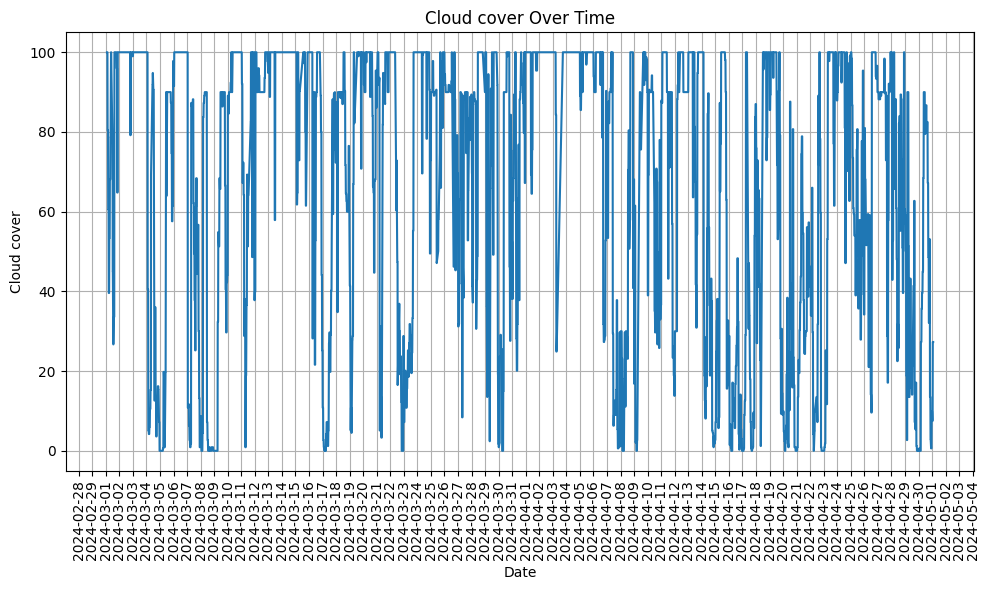

In [43]:
# plotting the cloud_cover over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['cloud_cover'], linestyle='-')
plt.title('Cloud cover Over Time')
plt.xlabel('Date')
plt.ylabel('Cloud cover')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

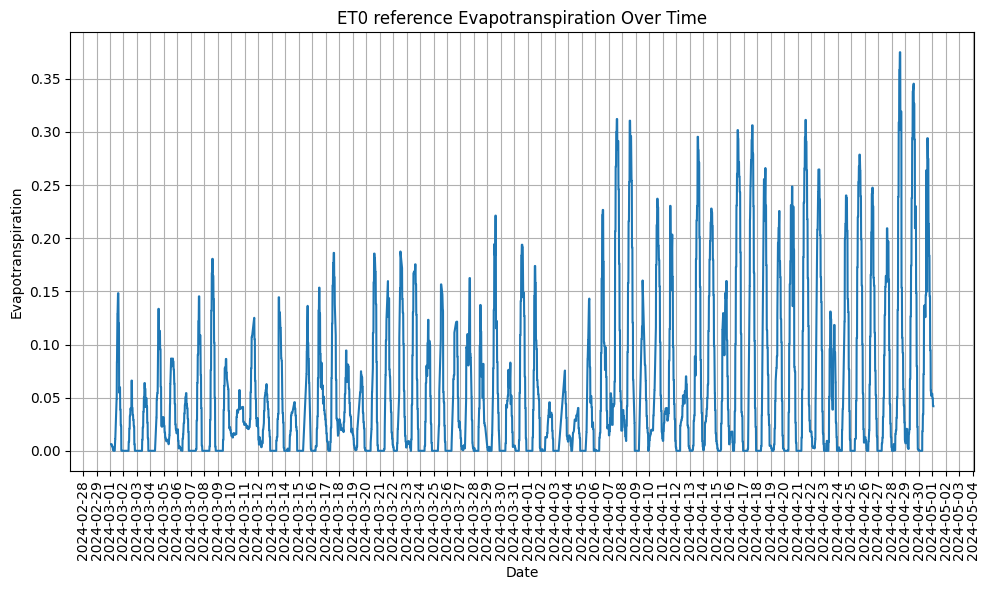

In [44]:
# plotting the et0_fao_evapotranspiration over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['et0_fao_evapotranspiration'], linestyle='-')
plt.title('ET0 reference Evapotranspiration Over Time')
plt.xlabel('Date')
plt.ylabel('Evapotranspiration')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

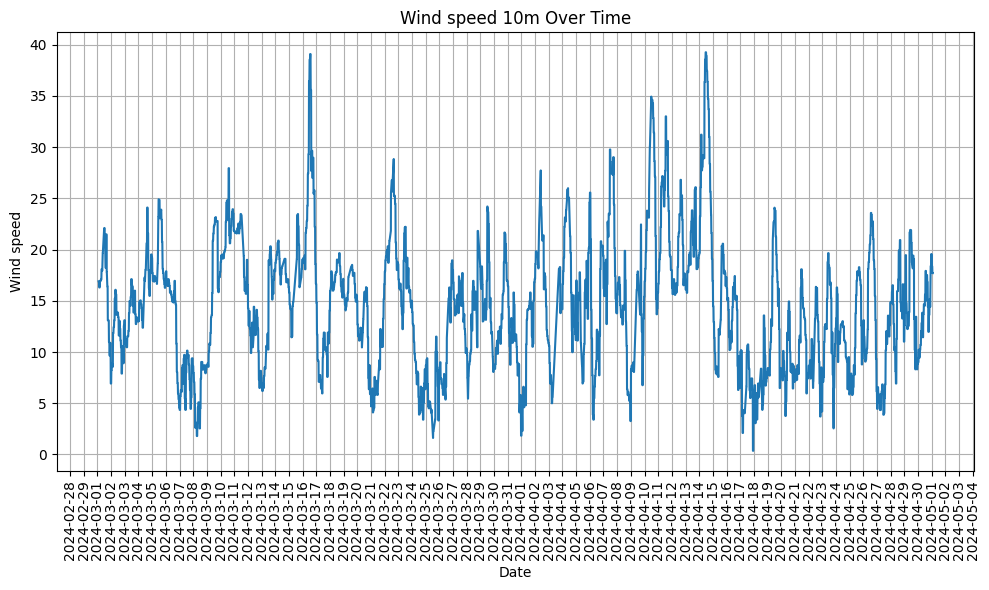

In [45]:
# plotting the wind_speed_10m over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['wind_speed_10m'], linestyle='-')
plt.title('Wind speed 10m Over Time')
plt.xlabel('Date')
plt.ylabel('Wind speed')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

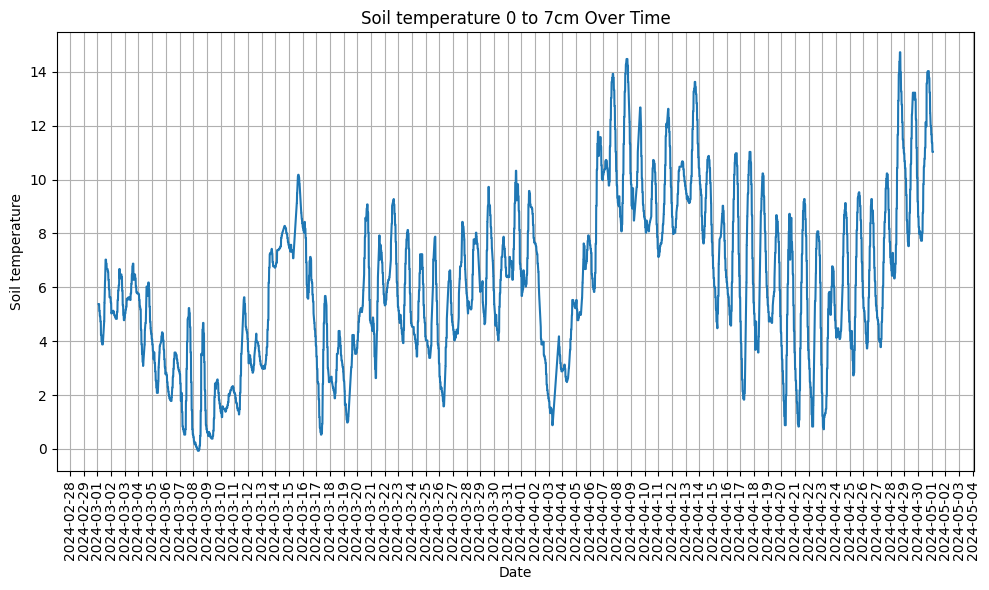

In [46]:
# plotting the soil_temperature_0_to_7cm over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['soil_temperature_0_to_7cm'], linestyle='-')
plt.title('Soil temperature 0 to 7cm Over Time')
plt.xlabel('Date')
plt.ylabel('Soil temperature')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

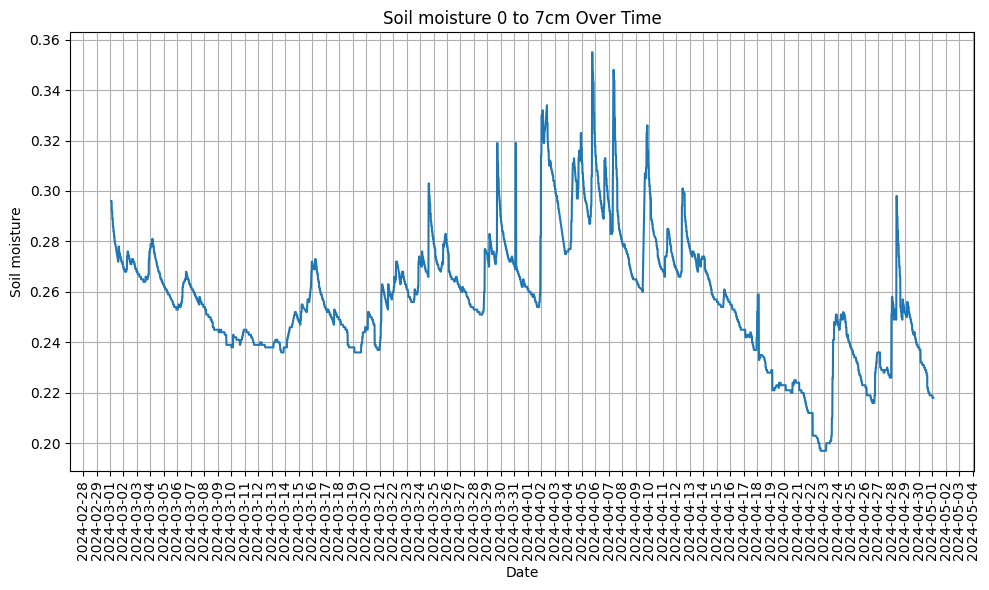

In [47]:
# plotting the soil_moisture_0_to_7cm over time
plt.figure(figsize=(10, 6))
plt.plot(df_combined_full['time'], df_combined_full['soil_moisture_0_to_7cm'], linestyle='-')
plt.title('Soil moisture 0 to 7cm Over Time')
plt.xlabel('Date')
plt.ylabel('Soil moisture')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

## 5. Unsupervised Machine Learning

### 5.1 UML: Magnetic field data

Clustering was done in 1_historic_api_feature_pipeline

### We have already clustered the data accordingly and labeled it in mag_cluster

<BarContainer object of 2 artists>

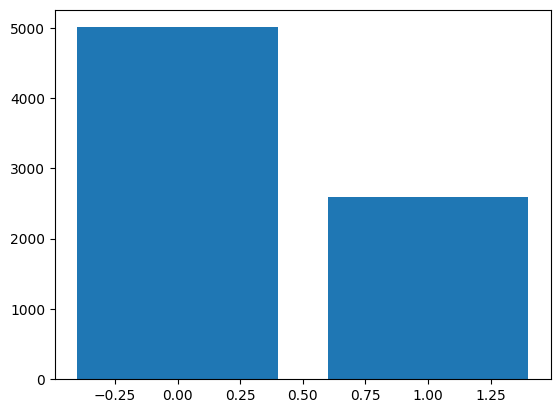

In [37]:
# Checking distribution of different values in mag_cluster values in barplot   
plt.bar(np.arange(2), df_combined_full['mag_cluster'].value_counts().values, align='center') # plot histogram for x and y data

Finding the most optimal ammount of clusters

In [38]:
# Saving the magnetic field data in a new dataframe 
mag = df_combined_full[["x","y","z"]]
# Normalizing the data
scaler = StandardScaler()
mag_normalized = scaler.fit_transform(mag)

**Silhouette score**

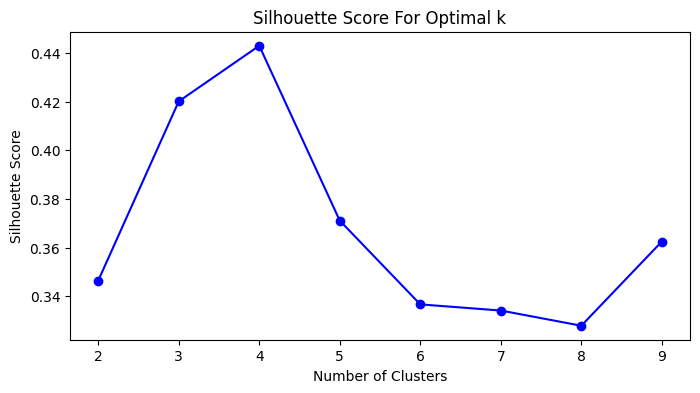

In [39]:
silhouette_avg = []
for k in range(2, 10):  # Starts from 2 clusters 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(mag_normalized, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_avg, 'bo-')  # Adjust the range as needed
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

**Elbow method**

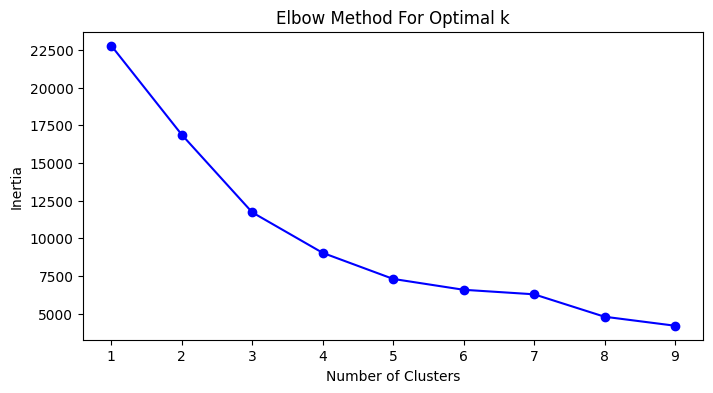

In [40]:
inertia = []
for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, 'bo-') 
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

**Visualising the clusters**

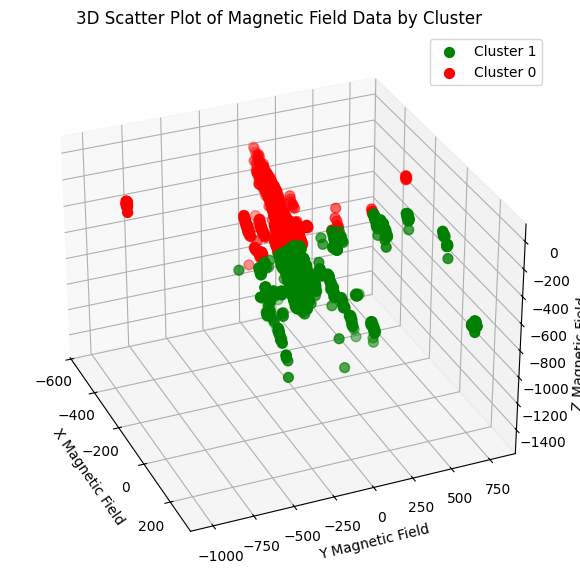

In [41]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# List of colors, ensure you have enough colors for your clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'pink', 'lightblue', 'lightgreen']

# Convert the 'mag_cluster' column to a categorical type and then to integer codes
df_combined_full['mag_cluster_encoded'] = df_combined_full['mag_cluster'].astype('category').cat.codes

# Loop through each cluster 
for i in df_combined_full['mag_cluster_encoded'].unique():
    # Extract data points belonging to the current cluster
    cluster_data = df_combined_full[df_combined_full['mag_cluster_encoded'] == i]
    ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], s=50, color=colors[i], label=f'Cluster {i}')

ax.set_xlabel('X Magnetic Field')
ax.set_ylabel('Y Magnetic Field')
ax.set_zlabel('Z Magnetic Field')
ax.set_title('3D Scatter Plot of Magnetic Field Data by Cluster')
ax.legend()

# Set the view angle
ax.view_init(elev=30, azim=-23
)

plt.show()

### 5.2 UML - Radar Data

In [42]:
# Saving the radar data in a new dataframe
rad = df_combined_full[['radar_0', 'radar_1',
       'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7']]

In [43]:
# Normalize the data
scaler = StandardScaler()
rad_normalized = scaler.fit_transform(rad)

In [44]:
# Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(rad_normalized)

# Adding cluster labels to original data
rad['rad_cluster'] = kmeans.labels_

# Checking the result
rad.head()

/tmp/ipykernel_28964/1010965370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad['rad_cluster'] = kmeans.labels_


,radar_0,radar_1,radar_2,radar_3,radar_4,radar_5,radar_6,radar_7,rad_cluster
7665,6.0,6.0,6.0,6.0,7.0,7.0,7.0,4.0,0
7666,6.0,6.0,6.0,6.0,7.0,7.0,7.0,4.0,0
7667,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,0
7668,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,0
7669,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,0


<BarContainer object of 2 artists>

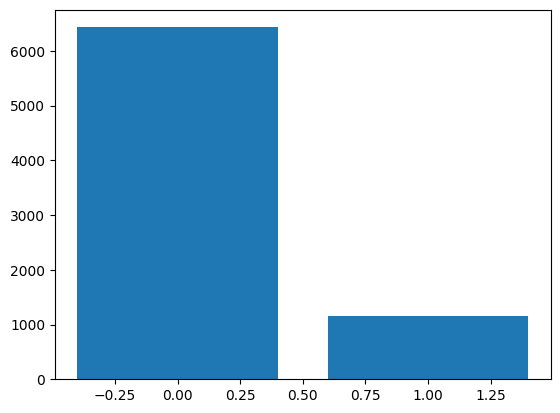

In [45]:
# Checking distribution of different values in mag_cluster values in barplot 
plt.bar(np.arange(2), df_combined_full['radar_cluster'].value_counts().values, align='center') 

We'll also make a new column showing the difference between the two clusterings

In [46]:
df_combined_full

,time,battery,temperature,x,y,z,radar_0,radar_1,radar_2,radar_3,...,psensor,id,mag_cluster,radar_cluster,date,hour,day_of_week,day_name,package_type_encoded,mag_cluster_encoded
7665,2024-03-01 02:00:32.251,3.04,5.250,-253.0,-27.0,-630.0,6.0,6.0,6.0,6.0,...,BIKELANE,2024-03-01 00:00:32.251_BIKELANE,no_detection,no_detection,2024-03-01,2,4,Friday,1,1
7666,2024-03-01 02:10:32.251,3.04,5.250,-254.0,-20.0,-627.0,6.0,6.0,6.0,6.0,...,BIKELANE,2024-03-01 00:10:32.251_BIKELANE,no_detection,no_detection,2024-03-01,2,4,Friday,1,1
7667,2024-03-01 02:20:33.352,3.04,5.250,-254.0,-23.0,-635.0,5.0,5.0,5.0,5.0,...,BIKELANE,2024-03-01 00:20:33.352_BIKELANE,no_detection,no_detection,2024-03-01,2,4,Friday,1,1
7668,2024-03-01 02:30:34.352,3.04,5.250,-256.0,-25.0,-628.0,5.0,5.0,5.0,5.0,...,BIKELANE,2024-03-01 00:30:34.352_BIKELANE,no_detection,no_detection,2024-03-01,2,4,Friday,1,1
7669,2024-03-01 02:40:33.352,3.04,5.250,-253.0,-28.0,-630.0,5.0,5.0,5.0,5.0,...,BIKELANE,2024-03-01 00:40:33.352_BIKELANE,no_detection,no_detection,2024-03-01,2,4,Friday,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15255,2024-05-01 01:13:42.182,3.08,11.125,-202.0,-7.0,-458.0,6.0,6.0,4.0,6.0,...,BIKELANE,2024-04-30 23:13:42.182_BIKELANE,detection,no_detection,2024-05-01,1,2,Wednesday,1,0
15256,2024-05-01 01:23:44.182,3.08,11.125,-202.0,-9.0,-455.0,6.0,6.0,4.0,6.0,...,BIKELANE,2024-04-30 23:23:44.182_BIKELANE,detection,no_detection,2024-05-01,1,2,Wednesday,1,0
15257,2024-05-01 01:33:44.429,3.08,11.000,-199.0,-8.0,-462.0,6.0,6.0,6.0,6.0,...,BIKELANE,2024-04-30 23:33:44.429_BIKELANE,detection,no_detection,2024-05-01,1,2,Wednesday,1,0
15258,2024-05-01 01:43:43.429,3.08,10.875,-199.0,-10.0,-463.0,6.0,6.0,6.0,6.0,...,BIKELANE,2024-04-30 23:43:43.429_BIKELANE,detection,no_detection,2024-05-01,1,2,Wednesday,1,0


Comparing Radar clusters and Magnetic field clusters

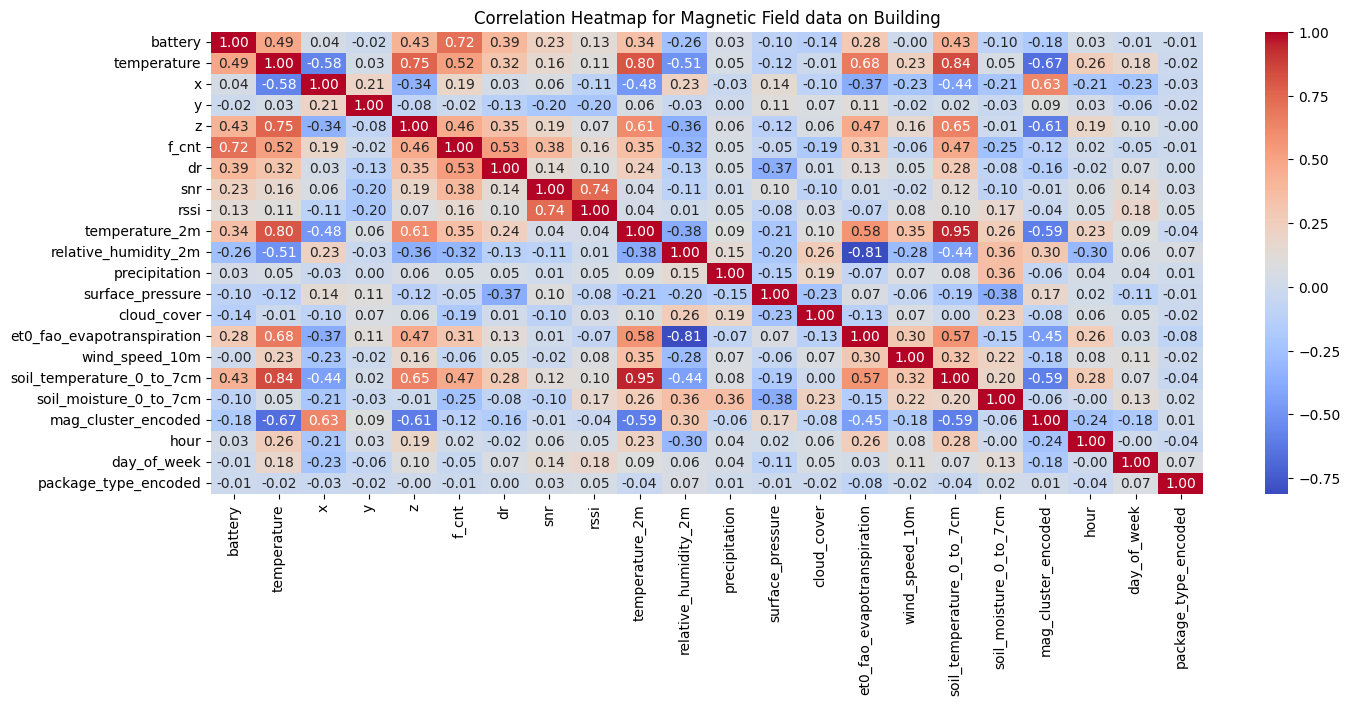

In [47]:
cm_mag = df_combined_full[['battery', 'temperature', 'x', 'y', 'z', 'f_cnt', 'dr', 'snr', 'rssi', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'surface_pressure', 'cloud_cover', 'et0_fao_evapotranspiration',
       'wind_speed_10m', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'mag_cluster_encoded', 'hour',
       'day_of_week', 'package_type_encoded']].corr()

# Plotting heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(cm_mag, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Magnetic Field data on Building')
plt.show()

In [48]:
# Convert the 'mag_cluster' column to a categorical type and then to integer codes
df_combined_full['radar_cluster_encoded'] = df_combined_full['radar_cluster'].astype('category').cat.codes

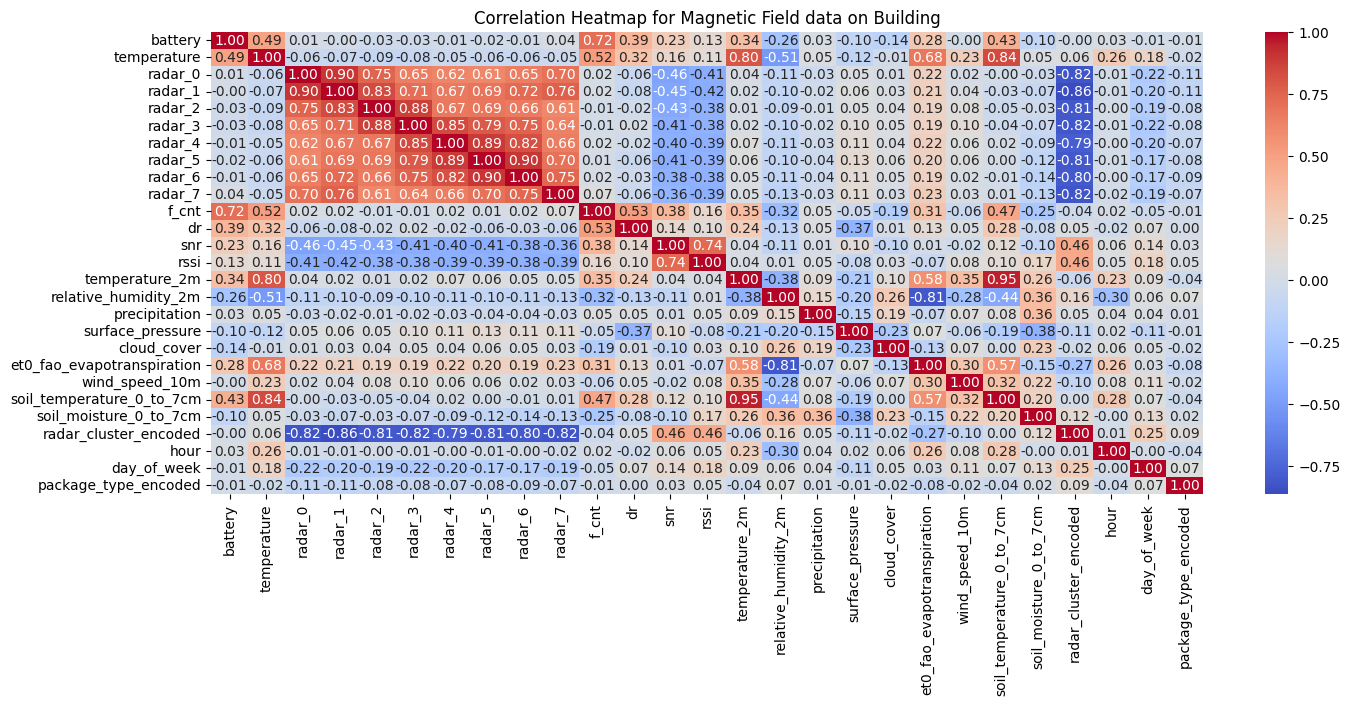

In [49]:
cm_radar = df_combined_full[['battery', 'temperature', 'radar_0', 'radar_1',
       'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7', 'f_cnt', 'dr', 'snr', 'rssi', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'surface_pressure', 'cloud_cover', 'et0_fao_evapotranspiration',
       'wind_speed_10m', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'radar_cluster_encoded', 'hour',
       'day_of_week', 'package_type_encoded']].corr()

# Plotting heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(cm_radar, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Magnetic Field data on Building')
plt.show()

In [50]:
df_combined_full['mag_cluster_encoded'].value_counts()

mag_cluster_encoded
1    5006
0    2589
Name: count, dtype: int64

In [51]:
df_combined_full['radar_cluster_encoded'].value_counts()

radar_cluster_encoded
1    6431
0    1164
Name: count, dtype: int64

In [52]:
# Comparing the clusters with the detection status
df_combined_full.groupby(['radar_cluster', 'mag_cluster']).size()

radar_cluster  mag_cluster 
detection      detection        293
               no_detection     871
no_detection   detection       2296
               no_detection    4135
dtype: int64

## PCA on Radar and Magnetic data

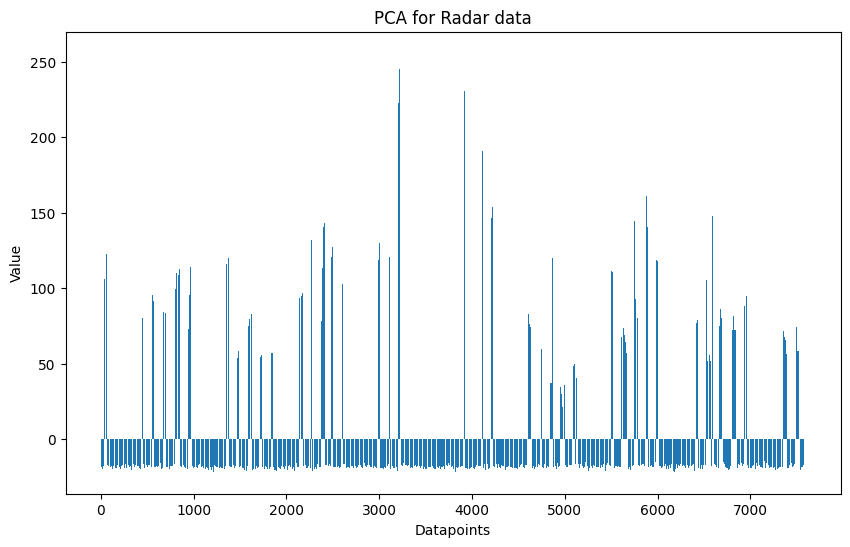

In [53]:
# First radar
radar_columns = ['radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7']
radar_data = df_combined_full[radar_columns]

pca = PCA(n_components=1)
reduced_data = pca.fit_transform(radar_data)

reduced_df = pd.DataFrame(reduced_data, columns=['PCA1'])

plt.figure(figsize=(10, 6))
plt.bar(range(len(reduced_df)), reduced_df['PCA1'])
plt.title('PCA for Radar data')
plt.xlabel('Datapoints')
plt.ylabel('Value')
plt.show()

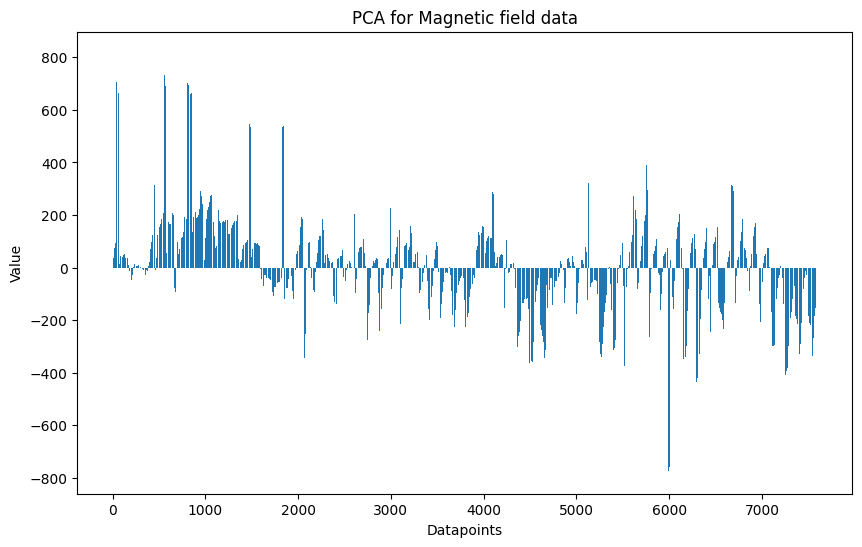

In [54]:
# Now magnetic field data
selected_columns = ['x', 'y', 'z']
selected_data = df_combined_full[selected_columns]

pca = PCA(n_components=1)
reduced_data = pca.fit_transform(selected_data)

reduced_df = pd.DataFrame(reduced_data, columns=['PCA1'])

plt.figure(figsize=(10, 6))
plt.bar(range(len(reduced_df)), reduced_df['PCA1'])
plt.title('PCA for Magnetic field data')
plt.xlabel('Datapoints')
plt.ylabel('Value')
plt.show()

# Regression analysis

In [55]:
df_combined_full['comparison_result'] = (df_combined_full['mag_cluster_encoded'] == df_combined_full['radar_cluster_encoded']).astype(int)

feature_columns = [
    'temperature','temperature_2m', 'relative_humidity_2m', 'precipitation',
       'surface_pressure', 'cloud_cover', 'et0_fao_evapotranspiration',
       'wind_speed_10m', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm'
]
target_column = 'comparison_result'

# THIS IS NOW STRAIGHT FORWARD
X = df_combined_full[feature_columns]
y = df_combined_full[target_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# WE USE LOGISTIC AS WE HAVE 0 OR 1 FOR DIFFERENT AND EQUAL PREDICTION
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.8084265964450297
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       617
           1       0.80      0.90      0.85       902

    accuracy                           0.81      1519
   macro avg       0.81      0.79      0.80      1519
weighted avg       0.81      0.81      0.80      1519



Feature Importance:
                      Feature  Coefficient
8   soil_temperature_0_to_7cm     1.915891
3               precipitation     0.089368
4            surface_pressure     0.055046
9      soil_moisture_0_to_7cm    -0.038388
5                 cloud_cover    -0.101317
7              wind_speed_10m    -0.230493
2        relative_humidity_2m    -0.719104
1              temperature_2m    -1.229253
6  et0_fao_evapotranspiration    -1.454062
0                 temperature    -2.595876


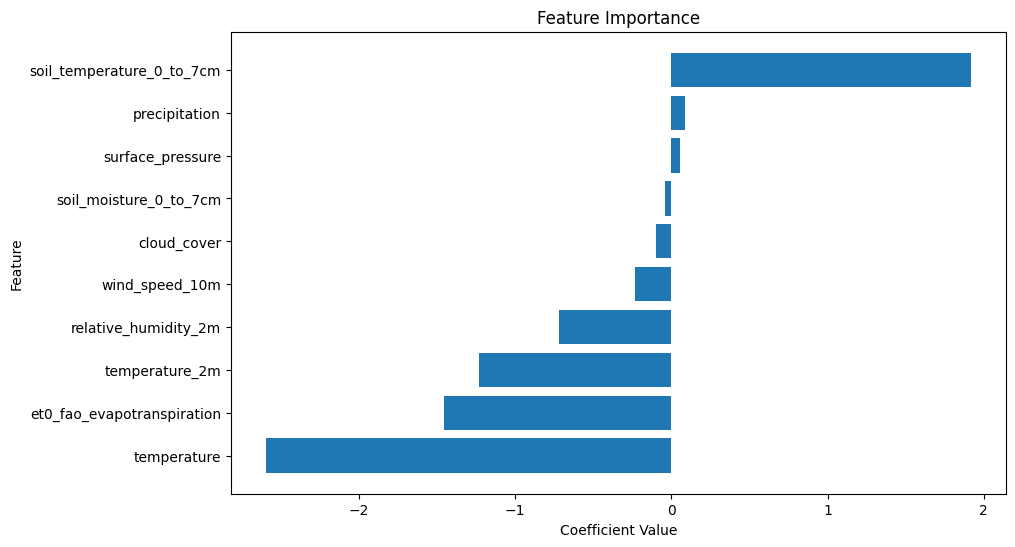

In [56]:
# FEATURE INFLUENCE OF THE MODEL 
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To have the highest values on top
plt.show()

In [57]:
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = sm.add_constant(X_scaled)

model = sm.Logit(y, X_scaled)
result = model.fit()

print(result.summary())

# WE CREATE STANDARD LOGIT OUTPUT
regression_results = pd.DataFrame({
    'Feature': ['Intercept'] + feature_columns,
    'Coefficient': result.params,
    'P-value': result.pvalues,
    'Standard Error': result.bse,
    'Odds Ratio': np.exp(result.params)
})

print("\nRegression Results:")
print(regression_results)

Optimization terminated successfully.
         Current function value: 0.415304
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      comparison_result   No. Observations:                 7595
Model:                          Logit   Df Residuals:                     7584
Method:                           MLE   Df Model:                           10
Date:                Sat, 25 May 2024   Pseudo R-squ.:                  0.3886
Time:                        09:53:17   Log-Likelihood:                -3154.2
converged:                       True   LL-Null:                       -5159.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1637      0.036      4.571      0.000       0.093       0.234
x1            -2.6377      0.

# Feature selection

Based on the results of the correlation matrix and the Logit Regression test, we choose temperature mesured by the sensor and et0_fao_evapotranspiration variable from the weather data to include in our models along side the magnetic or radar readings.

In [58]:
# first we import the CSV file where radar data is not backfilled
df_radar = pd.read_csv('../bikelane_radar_df.csv')

In [66]:
#encoding the radar_cluster column
df_radar['radar_cluster'] = df_radar['radar_cluster'].astype('category').cat.codes
radar_features = df_radar[['radar_0', 'radar_1', 'radar_2', 'radar_3', 'radar_4', 'radar_5', 'radar_6', 'radar_7', 'temperature', 'et0_fao_evapotranspiration', 'radar_cluster']]

In [67]:
print(radar_features.shape)

(2628, 11)


In [68]:
radar_features.head()

,radar_0,radar_1,radar_2,radar_3,radar_4,radar_5,radar_6,radar_7,temperature,et0_fao_evapotranspiration,radar_cluster
0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,4.0,5.250,0.006267,1
1,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,5.250,0.006267,1
2,6.0,6.0,6.0,5.0,5.0,4.0,5.0,6.0,5.125,0.004743,1
3,5.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.000,0.004743,1
4,5.0,6.0,6.0,6.0,5.0,5.0,5.0,6.0,4.625,0.003818,1


In [69]:
mag_features = df_combined_full[['x', 'y', 'z', 'temperature', 'et0_fao_evapotranspiration', 'mag_cluster_encoded']]

In [70]:
mag_features.head()

,x,y,z,temperature,et0_fao_evapotranspiration,mag_cluster_encoded
7665,-253.0,-27.0,-630.0,5.25,0.006267,1
7666,-254.0,-20.0,-627.0,5.25,0.006267,1
7667,-254.0,-23.0,-635.0,5.25,0.006267,1
7668,-256.0,-25.0,-628.0,5.25,0.006267,1
7669,-253.0,-28.0,-630.0,5.25,0.006267,1


# Modeling

In this section we want to try out some different models suited for binary classification.

Traditional ML models:

* k-Nearest Neighbor (KNN)

* Logistic Regression (LR)

* Support vector machine (SVM)

Deep learning model:

* Long short term memory (LSTM)

In [72]:
#loading the ML models

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [76]:
# We split the data into training and testing sets by first separating the features and the target variable
X_radar = radar_features.drop('radar_cluster', axis=1)
y_radar = radar_features['radar_cluster']
x_mag = mag_features.drop('mag_cluster_encoded', axis=1)
y_mag = mag_features['mag_cluster_encoded']


In [77]:
# Splitting the data into training and testing sets with 80% of the data for training and 20% for testing
x_radar_train, x_radar_test, y_radar_train, y_radar_test = train_test_split(X_radar, y_radar, test_size=0.2, random_state=42)
x_mag_train, x_mag_test, y_mag_train, y_mag_test = train_test_split(x_mag, y_mag, test_size=0.2, random_state=42)

In [78]:
# Logistic Regression
logistic_radar = LogisticRegression(max_iter=1000)
logistic_radar.fit(x_radar_train, y_radar_train)
logistic_mag = LogisticRegression(max_iter=1000)
logistic_mag.fit(x_mag_train, y_mag_train)

LogisticRegression(max_iter=1000)

In [79]:
# Displaying the accuracy of the model
print("Logistic Regression Model Accuracy:")
print("Radar data:", logistic_radar.score(x_radar_test, y_radar_test))
print("Magnetic field data:", logistic_mag.score(x_mag_test, y_mag_test))

Logistic Regression Model Accuracy:
Radar data: 0.9942965779467681
Magnetic field data: 1.0


In [80]:
# Support Vector Machine
svm_radar = SVC()
svm_radar.fit(x_radar_train, y_radar_train)
svm_mag = SVC()
svm_mag.fit(x_mag_train, y_mag_train)


SVC()

In [81]:
# Displaying the accuracy of the model
print("Support Vector Machine Model Accuracy:")
print("Radar data:", svm_radar.score(x_radar_test, y_radar_test))
print("Magnetic field data:", svm_mag.score(x_mag_test, y_mag_test))


Support Vector Machine Model Accuracy:
Radar data: 0.9923954372623575
Magnetic field data: 0.9835418038183015


In [82]:
# k-Nearest Neighbors
knn_radar = KNeighborsClassifier()
knn_radar.fit(x_radar_train, y_radar_train)
knn_mag = KNeighborsClassifier()
knn_mag.fit(x_mag_train, y_mag_train)


KNeighborsClassifier()

In [83]:
# Displaying the accuracy of the model
print("k-Nearest Neighbors Model Accuracy:")
print("Radar data:", knn_radar.score(x_radar_test, y_radar_test))
print("Magnetic field data:", knn_mag.score(x_mag_test, y_mag_test))


k-Nearest Neighbors Model Accuracy:
Radar data: 0.9942965779467681
Magnetic field data: 0.9921000658327848


In [88]:
# importing LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error


2024-05-25 10:22:23.284456: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:22:24.326177: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:22:26.631037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 10:22:29.570741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [90]:
# create and fit the LSTM network
model = Sequential()
look_back = 1
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_radar_train, y_radar_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2102/2102 - 4s - 2ms/step - loss: 0.1206
Epoch 2/10
2102/2102 - 3s - 2ms/step - loss: 0.0062
Epoch 3/10
2102/2102 - 5s - 3ms/step - loss: 0.0057
Epoch 4/10
2102/2102 - 3s - 2ms/step - loss: 0.0053
Epoch 5/10
2102/2102 - 3s - 2ms/step - loss: 0.0046
Epoch 6/10
2102/2102 - 4s - 2ms/step - loss: 0.0048
Epoch 7/10
2102/2102 - 5s - 2ms/step - loss: 0.0048
Epoch 8/10
2102/2102 - 4s - 2ms/step - loss: 0.0048
Epoch 9/10
2102/2102 - 3s - 2ms/step - loss: 0.0045
Epoch 10/10
2102/2102 - 3s - 2ms/step - loss: 0.0045


In [97]:
# make predictions
trainPredict = model.predict(x_radar_train)
testPredict = model.predict(x_radar_test)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_radar_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_radar_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 0.06 RMSE
Test Score: 0.08 RMSE
